## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Colab Notebooks/oleg/Prac5'

/content/drive/My Drive/Colab Notebooks/oleg/Prac5


In [0]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [0]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [0]:
images_train, labels_train = next(iter(train_loader))

In [0]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

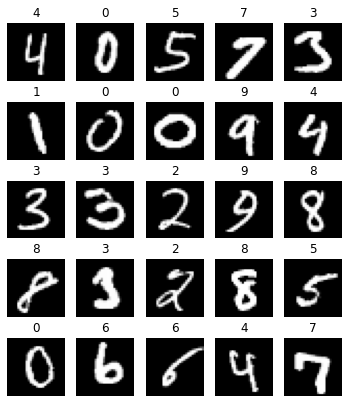

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [0]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [0]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [0]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def he(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / weight.size()[0]
    weight.normal_(mean=0, std=np.sqrt(d))


def build_net(init_f,activation):
    net = []
    net.append(make_linear(28*28, 500, init_f))
    net.append(activation)
    
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
        net.append(activation)
        
    net.append(make_linear(500, 10, init_f))
    net.append(activation)
    
    net = nn.Sequential(*net)
    return net

#пример:
net=build_net(dumb_init,torch.nn.Tanh())
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9933679699897766
forward 0.9848348498344421
forward 0.9813675880432129
forward 0.9816268682479858
forward 0.9810954928398132
forward 0.981575608253479
forward 0.9817988276481628
forward 0.9808768033981323
forward 0.9816756844520569
forward 0.9815468192100525
backward 0.0047434065490961075
backward 0.0020023812539875507
backward 0.0060992250218987465
backward 0.018718421459197998
backward 0.05938049405813217
backward 0.1781100481748581
backward 0.6058553457260132
backward 2.3272969722747803
backward 7.21035623550415
backward 21.072349548339844


***Чем глубже слой, тем больше std<br>
Растёт только градиент, но это не верно в общем случае***

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [0]:
net=build_net(xavier_init_uni,torch.nn.Tanh())
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9933679699897766
forward 0.6493523120880127
forward 0.4914759397506714
forward 0.41076192259788513
forward 0.3580806851387024
forward 0.3214036822319031
forward 0.29073500633239746
forward 0.2683130204677582
forward 0.25069543719291687
forward 0.23663657903671265
backward 0.029561270028352737
backward 0.01732303574681282
backward 0.016118474304676056
backward 0.015232838690280914
backward 0.01388881728053093
backward 0.012127837166190147
backward 0.010154417715966702
backward 0.00860538799315691
backward 0.006801027804613113
backward 0.003923469223082066


In [0]:
net=build_net(xavier_init_uni,torch.nn.ReLU())
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9933679699897766
forward 0.64744633436203
forward 0.46114152669906616
forward 0.3243381381034851
forward 0.23392285406589508
forward 0.17287984490394592
forward 0.12026698142290115
forward 0.08635682612657547
forward 0.06442867964506149
forward 0.042582470923662186
backward 0.04605551436543465
backward 0.011682544834911823
backward 0.007106746081262827
backward 0.004571299068629742
backward 0.0031968681141734123
backward 0.0019872612319886684
backward 0.0013723172014579177
backward 0.0009196480386890471
backward 0.0005762145738117397
backward 0.0003539571480359882


In [0]:
net=build_net(he,torch.nn.ReLU())
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9933679699897766
forward 1.0280500650405884
forward 1.0374479293823242
forward 0.9991914629936218
forward 0.9200089573860168
forward 0.8948942422866821
forward 0.9156867265701294
forward 0.90521639585495
forward 0.957207977771759
forward 0.9288811087608337
backward 0.044981472194194794
backward 0.05974045768380165
backward 0.060044318437576294
backward 0.05339638516306877
backward 0.0497467964887619
backward 0.04157023876905441
backward 0.04106801748275757
backward 0.036045391112565994
backward 0.03267928212881088
backward 0.033220432698726654


<i> 1.4 Сделайте выводы по первой части </i>

***Благодаря правильно инициализации дисперсия скачет не особо сильно<br>
Для ReLU лучше использовать He***

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [0]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [0]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 14... (Train/Test) NLL: 0.590/0.310	Accuracy: 0.853/0.930


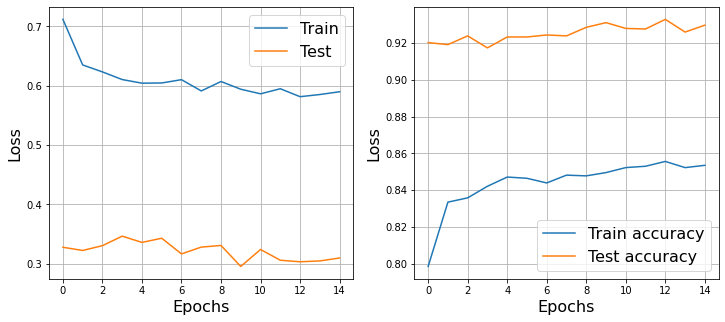

([0.7119508596625663,
  0.6350696325175035,
  0.6233734212069115,
  0.6104632265278017,
  0.6043632547738456,
  0.6047036333887308,
  0.610267740958281,
  0.5912673123863968,
  0.6071541723030717,
  0.5941613376267684,
  0.5864181925874274,
  0.5949943565102275,
  0.5815847154492254,
  0.5852288130376893,
  0.5899194276282019],
 [0.32770719992209085,
  0.3223321869780746,
  0.33043494877181473,
  0.3464506647632092,
  0.335930308303501,
  0.34296357405336597,
  0.3165176016620443,
  0.327985439308082,
  0.3307764444358741,
  0.2953881296930434,
  0.3240078761230541,
  0.30583491996873785,
  0.30327434413417986,
  0.30468151652360265,
  0.30967104736762713],
 [0.79844636,
  0.8334555,
  0.83578205,
  0.8420842,
  0.84711486,
  0.8464319,
  0.8438999,
  0.84814763,
  0.8477534,
  0.84954137,
  0.8522566,
  0.85298955,
  0.85561585,
  0.85224545,
  0.8534893],
 [0.92029274,
  0.9192049,
  0.92395175,
  0.91742486,
  0.9233584,
  0.9233584,
  0.9244462,
  0.92395175,
  0.92859966,
  0.9311

In [24]:
train(net, train_loader, test_loader, 15, 0.01, device='cuda')

In [0]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 14... (Train/Test) NLL: 0.235/0.133	Accuracy: 0.941/0.969


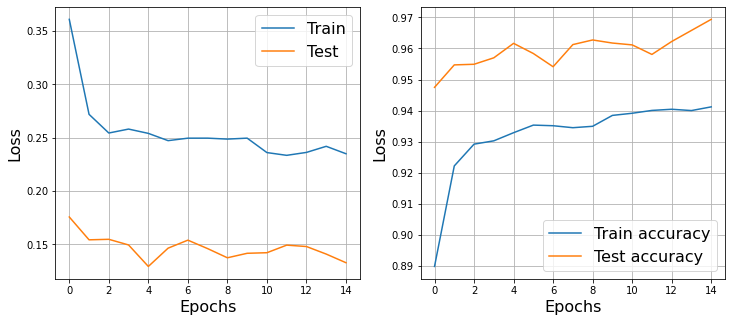

([0.36101617033420597,
  0.27195837428130065,
  0.2544418513330061,
  0.25813911624872354,
  0.2541065585177972,
  0.24729141088595777,
  0.24961272789153463,
  0.24963829314499014,
  0.24873786955785904,
  0.24963629866110237,
  0.2361000970339597,
  0.2335200298235996,
  0.23626243141986158,
  0.24197582511314705,
  0.23501074791494717],
 [0.175717437474788,
  0.15430493549078325,
  0.1547790019761158,
  0.14949048772642884,
  0.12933946914876562,
  0.14649181579581544,
  0.15399262474118908,
  0.14606110723335533,
  0.13745979780826387,
  0.14167308434844017,
  0.14221433630283875,
  0.14931264821487136,
  0.1480176419585566,
  0.1409409843102286,
  0.13283238444430165],
 [0.8899198,
  0.92223597,
  0.9292322,
  0.9302983,
  0.932908,
  0.93535113,
  0.9351513,
  0.9345183,
  0.934968,
  0.9384717,
  0.9391602,
  0.9400708,
  0.9404429,
  0.94002646,
  0.9412147],
 [0.9474881,
  0.95470726,
  0.9549051,
  0.9569818,
  0.96162975,
  0.9583663,
  0.9541139,
  0.96123415,
  0.9627176,


In [26]:
train(net, train_loader, test_loader, 15, 0.01, device='cuda')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

***Dropout (или Dropconnect) избавляются от переобучения. <br>
Интересно, что на тесте мы получаем лучшие результаты, чем на train, это <br>
связяно с двумя вещами:<br>
1) Лосс на train мы считаем как среднее по эпохе (то есть во время обучения), а лосс на тесте мы считаем в конце эпохи (то есть модель уже достаточно хорошо выучилась)<br>
2) Во время обучения мы зануляем некоторые нейроны (веса), а во время теста они опять могут оказывать влиянеие<br><br>
DropConnect в данном случае показал себя значительно лучше (хотя всё зависит от конкретной задачи и величины p)***

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [0]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        u=x.sum(axis=1)/x.size(1)
        d=(((x-u[...,None])**2).sum(axis=1)/x.size(1))**(1/2)
        output = (x-u[...,None])/d[...,None]
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [0]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.BatchNorm1d(out_dim))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.043/0.080	Accuracy: 0.986/0.975


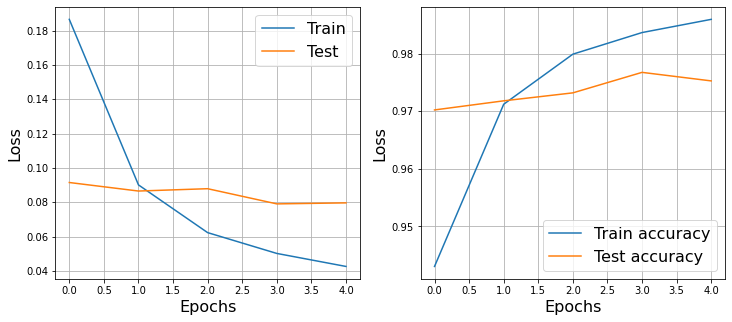

([0.18659854595309128,
  0.09010384208373805,
  0.06227860621202475,
  0.05014621824232627,
  0.042561466234730186],
 [0.09149203091105328,
  0.08651928917233702,
  0.08788103294334834,
  0.07903159395614757,
  0.07961781959556326],
 [0.94304705, 0.9712209, 0.9799218, 0.98367536, 0.9859686],
 [0.9702334, 0.97181565, 0.97320014, 0.97676027, 0.9752769])

In [20]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

In [0]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(LayerNormalization())
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.054/0.087	Accuracy: 0.982/0.973


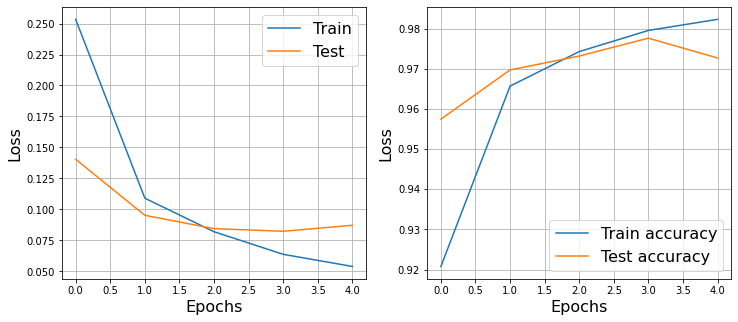

([0.25336284602660614,
  0.1090399049985002,
  0.08198106754372624,
  0.0637455910507804,
  0.05396062284827169],
 [0.14040890788730187,
  0.09522950562023663,
  0.08447796353905261,
  0.08234204766871053,
  0.08717865810458418],
 [0.9207756, 0.9657127, 0.9743082, 0.97957754, 0.98233724],
 [0.95747626, 0.9697389, 0.97320014, 0.97765034, 0.9727057])

In [22]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

***Батч (или лэйер) нормализация значительно ускоряет сходимость***

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: